In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pmagpy.ipmag as ipmag #can be pip installed if you don't have it
import pmagpy.pmag as pmag
import cartopy.crs as ccrs
#import seaborn as sns
%config InlineBackend.figure_format='retina'

from scripts.auxiliar import get_files_in_directory, spherical2cartesian

In [39]:
current_path = os.getcwd() 
data_path_PP = current_path + "/data/poles_NAM"
file_name = "/NAM_poles_0_130.xlsx"
df_NAM = pd.read_excel(data_path_PP + file_name)
df_NAM.columns

Index(['name', 'min_age', 'max_age', 'age', 'slat', 'slon', 'N', 'k',
       'alpha95', 'dp', 'dm', 'plat', 'plon', 'K', 'A95', 'plateID',
       'lithology', 'Rlat', 'Rlon', 'Euler_lat', 'Euler_lon', 'Euler_ang',
       'author', 'Q', 'reliability', 'age constraints'],
      dtype='object')

In [40]:
df_NAM.head()

,name,min_age,max_age,age,slat,slon,N,k,alpha95,dp,...,lithology,Rlat,Rlon,Euler_lat,Euler_lon,Euler_ang,author,Q,reliability,age constraints
0,USGS SW North America composite,0.0,1.0,0.5,36.30,242.13,38,24.7,4.8,NaN,...,volcanic,-86.3,5.7,0.0,0.0,0.0,Mankinen (2008),5,NaN,Brunhes normal chron
1,Michoacan Guanajuato volcanic ﬁeld,0.0,0.6,0.3,19.25,257.67,8,29.0,9.1,8.5,...,volcanic,-86.4,9.2,79.2,23.0,0.2,Maciel Peña et al. (2009),5,NaN,Ar-Ar ages of 82 to 612 ka (from another study)
2,Tequila volcanic ﬁelds,0.1,1.1,0.6,20.46,256.76,17,26.0,7.1,6.9,...,volcanic,-85.3,-94.1,79.9,22.7,0.3,Ceja et al. (2006),5,NaN,Ar/Ar ages of 0.115 to 1.13 Ma (from another s...
3,Trans Mexican Volcanic Belt,0.0,2.0,1.0,19.40,260.10,24,47.3,4.3,3.5,...,volcanic,-88.9,-75.1,79.9,22.7,0.3,Ruiz-Martínez et al. (2010),5,NaN,all Quaternary rocks (some K-Ar dated)
4,Katherine Creek sediments,0.0,3.0,1.5,65.00,232.40,100,9.1,4.9,7.9,...,clastics,-80.0,4.2,80.8,22.8,0.4,Barendregt et al. (1996),3,NaN,magnetostratigraphy


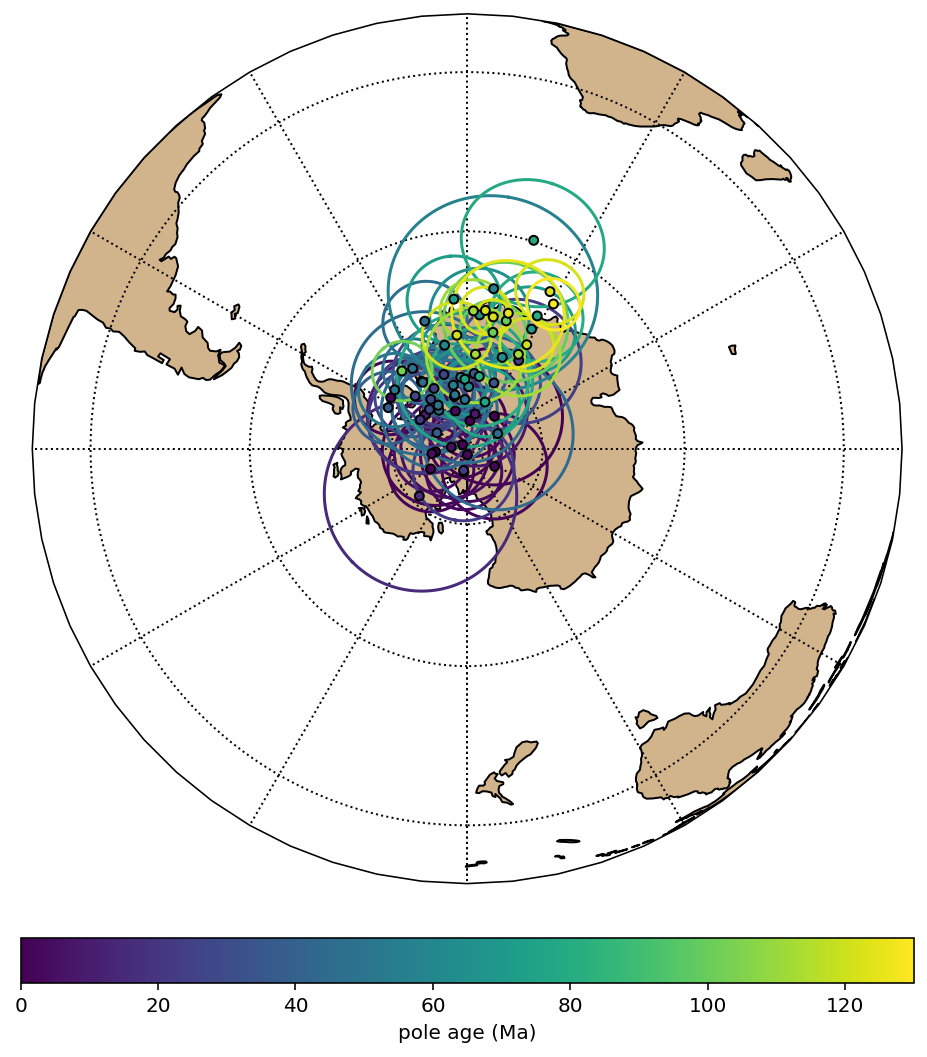

In [75]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, df_NAM.plon, df_NAM.plat, df_NAM.alpha95, df_NAM.age, 0, 130)
plt.show()

In [76]:
def running_mean_APWP(data,window_length,spacing,max_age,min_age,fig_name=None):
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['age','N','alpha95','plon','plat'])
    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['age'] >= window_min) & (data['age'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['plon'].tolist(),inc=poles['plat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
    return running_means

In [77]:
NA_RM_20_10 = running_mean_APWP(df_NAM,20,10,110,0)
NA_RM_20_10

,age,N,alpha95,plon,plat
0,0.0,14.0,2.451638,307.713863,-87.713097
10,10.0,15.0,2.518633,292.832373,-87.709272
20,20.0,11.0,3.710295,325.319043,-83.977929
30,30.0,13.0,3.056739,336.543106,-83.081653
40,40.0,14.0,2.764720,334.726672,-81.876509
50,50.0,12.0,3.627429,340.724562,-80.305351
60,60.0,11.0,3.659331,351.635982,-78.696684
70,70.0,12.0,4.153305,10.567316,-75.648617
80,80.0,7.0,6.838549,15.077436,-74.052240
90,90.0,4.0,5.702669,18.118438,-74.186230


In [78]:
NA_RM_20_10.age.tolist()

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0]

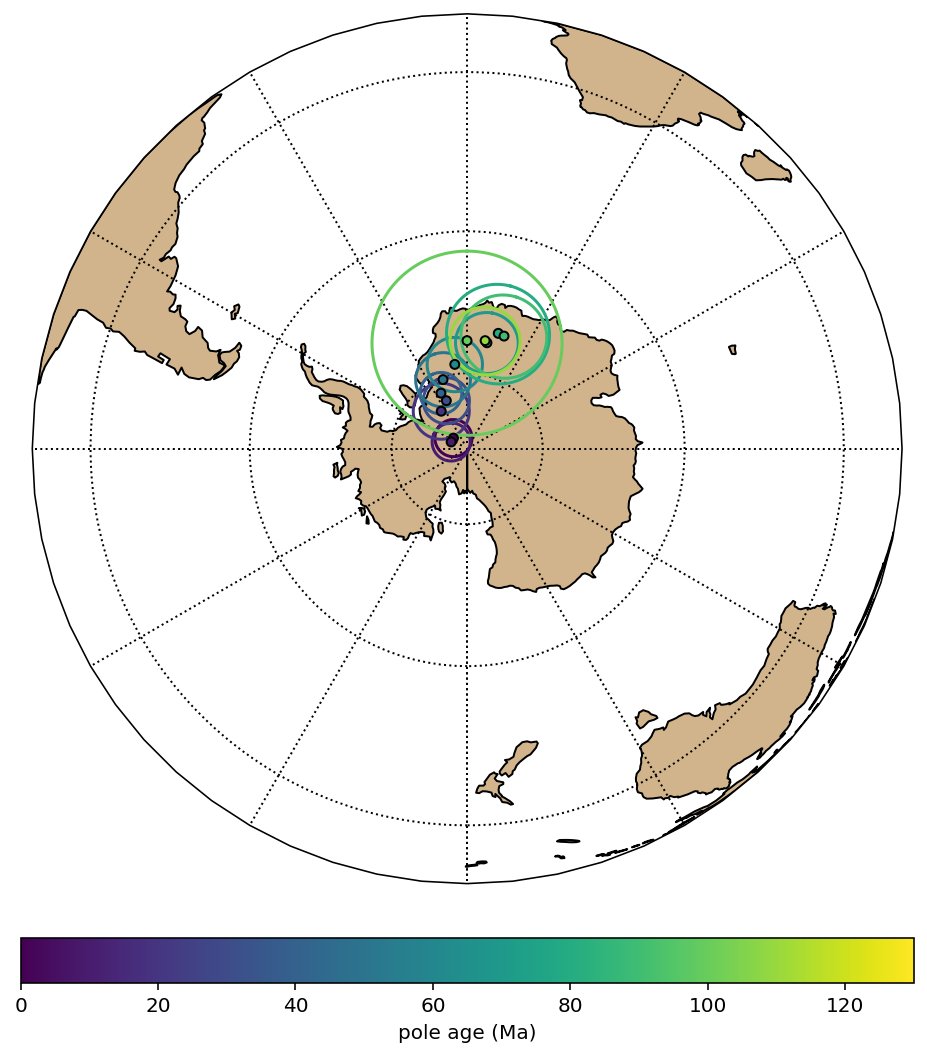

In [79]:
map_axis = ipmag.make_orthographic_map(central_longitude=0, central_latitude=-90, figsize=(10,10))
ipmag.plot_poles_colorbar(map_axis, NA_RM_20_10.plon.tolist(), NA_RM_20_10.plat.tolist(), 
                 NA_RM_20_10.alpha95.tolist(), NA_RM_20_10.age.tolist(),0,130)
plt.show()